In [14]:
# Create separate thread for ros
import threading
import rospy
import time
import os

# Setup

In [30]:
import roboy_middleware_msgs

In [40]:
msg = roboy_middleware_msgs.msg.MotorConfig()

In [41]:
msg.control_mode = 0

In [28]:
cmd = 'rosservice call /roboy/pinky/middleware/ControlMode "control_mode: 3  \r set_points: [0]  \r global_id: [3]"'
returned_value = os.system(cmd)
print('returned value:', returned_value)

returned value: 256


In [ ]:

rospy.init_node('motor_tester', anonymous=True)

In [3]:

motor_global_id = 3

shared_global_data = {
    'motor_pwm_sp': 0,
    'motor_pos_encoder_pv': 0,
    'motor_torque_encoder_pv': 0,
    'motor_current_pv': 0,
}


In [9]:
from  roboy_middleware_msgs.msg import MotorCommand

In [ ]:
!rosservice call /roboy/pinky/middleware/ControlMode "control_mode: 0
set_points: [0]
global_id: [3]"

# Pub thread - REMBEMBER TO SET IN PWM MODE TODO

In [5]:

# Create publisher thread
def ros_pub_thread():
    try:
        global shared_global_data
        topic = '/roboy/pinky/middleware/MotorCommand'
        pub = rospy.Publisher(topic, MotorCommand, queue_size=10)
        rate = rospy.Rate(10) # 10hz
        shared_global_data['motor_pwm_sp'] = 0 # reset pwm
        while not rospy.is_shutdown():
            msg = MotorCommand()
            msg.global_id = [motor_global_id]
            msg.setpoint = [shared_global_data['motor_pwm_sp']]
            pub.publish(msg)
            rate.sleep()
    except Exception as e:
        print(e)

# Start publisher thread
threading.Thread(target=ros_pub_thread).start()

In [45]:
# Stop publisher thread
rospy.signal_shutdown('shutdown')

In [72]:
import numpy as np

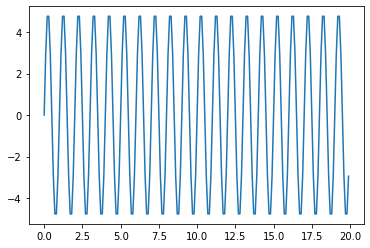

In [73]:
test_time = 20
dt = 0.1

amplitude = 5
frequency = 1

t = np.arange(0, test_time, dt)
y = np.sin(2 * np.pi * frequency * t) * amplitude

import matplotlib.pyplot as plt
plt.plot(t, y)

In [74]:
for i in range(len(y)):
    shared_global_data['motor_pwm_sp'] = y[i]
    time.sleep(dt)

shared_global_data['motor_pwm_sp'] = 0

# Sub thread

In [64]:
from  roboy_middleware_msgs.msg import MotorState

In [65]:
motor_state_topic = '/roboy/pinky/middleware/MotorState'

In [66]:
# Read topic
def motor_state_callback(data):
    global shared_global_data
    shared_global_data['motor_pos_encoder_pv'] = data.encoder1_pos[motor_global_id]
    shared_global_data['motor_torque_encoder_pv'] = data.encoder0_pos[motor_global_id]
    shared_global_data['motor_current_pv'] = data.current[motor_global_id]

# Create subscriber thread
def ros_sub_thread():
    try:
        rospy.Subscriber(motor_state_topic, MotorState, motor_state_callback)
        rospy.spin()
    except Exception as e:
        print(e)

# Start subscriber thread
threading.Thread(target=ros_sub_thread).start()

# Play area

In [71]:
shared_global_data

{'motor_pwm_sp': 0,
 'motor_pos_encoder_pv': -7524446.0,
 'motor_torque_encoder_pv': 302.0,
 'motor_current_pv': -0.05000000074505806}

In [56]:
shared_global_data['motor_pwm_sp'] = 0

In [76]:
# make while loop that gets the arrow keys and sets the pwm accordingly
while True:
    key = input("press u for up, d for down, q for stop")
    if key == 'u':

        shared_global_data['motor_pwm_sp'] = 10
        time.sleep(0.5)
        shared_global_data['motor_pwm_sp'] = 0
    if key == 'U':

        shared_global_data['motor_pwm_sp'] = 10
        time.sleep(2)
        shared_global_data['motor_pwm_sp'] = 0

    elif key == 'd':
        shared_global_data['motor_pwm_sp'] = -10
        time.sleep(0.5)
        shared_global_data['motor_pwm_sp'] = 0

    elif key == 'D':
        shared_global_data['motor_pwm_sp'] = -10
        time.sleep(2)
        shared_global_data['motor_pwm_sp'] = 0

    elif key == 'q':
        break

In [79]:
# Find the static pwm
while True:
    key = input("press u for up, d for down, q for stop")
    if key == 'u':
        shared_global_data['motor_pwm_sp'] += 1
    elif key == 'd':
        shared_global_data['motor_pwm_sp'] += -1
    elif key == 'q':
        break

static_pwm = shared_global_data['motor_pwm_sp']

In [80]:
static_pwm

4

In [83]:
# Find top position
while True:
    key = input("press u for up, d for down, q for stop")
    if key == 'u':
        shared_global_data['motor_pwm_sp'] += 1
    elif key == 'd':
        shared_global_data['motor_pwm_sp'] += -1
    elif key == 'q':
        break
  
shared_global_data['motor_pwm_sp'] = static_pwm

top_pos = shared_global_data['motor_pos_encoder_pv']

In [90]:
# Find bot position
while True:
    key = input("press u for up, d for down, q for stop")
    if key == 'u':
        shared_global_data['motor_pwm_sp'] += 1
    elif key == 'd':
        shared_global_data['motor_pwm_sp'] += -1
    elif key == 'q':
        break
  
shared_global_data['motor_pwm_sp'] = static_pwm

bot_pos = shared_global_data['motor_pos_encoder_pv']

In [104]:
normal_speed_up_pwm = static_pwm + 5
normal_speed_down_pwm = static_pwm - 3

In [126]:
def go_to_top_pos():
    # Go to top position
    while -shared_global_data['motor_pos_encoder_pv'] < -top_pos:
        shared_global_data['motor_pwm_sp'] = normal_speed_up_pwm
        time.sleep(0.1)
    shared_global_data['motor_pwm_sp'] = static_pwm

In [127]:
def go_to_bot_pos():
    # Go to bot position
    while -shared_global_data['motor_pos_encoder_pv'] > -bot_pos:
        shared_global_data['motor_pwm_sp'] = normal_speed_down_pwm
        time.sleep(0.1)
    shared_global_data['motor_pwm_sp'] = static_pwm

In [128]:
def go_to_middle_position():
  # Go to middle position
  while np.abs(np.abs(top_pos + bot_pos)/2 - np.abs(shared_global_data['motor_pos_encoder_pv'])) > np.abs(top_pos - bot_pos)/20:

      # While over middle position
      if np.abs(top_pos + bot_pos)/2 < shared_global_data['motor_pos_encoder_pv']:
        shared_global_data['motor_pwm_sp'] = normal_speed_down_pwm
      
      # While under middle position
      if np.abs(top_pos + bot_pos)/2 > shared_global_data['motor_pos_encoder_pv']:
        shared_global_data['motor_pwm_sp'] = normal_speed_up_pwm
      time.sleep(0.1)

  shared_global_data['motor_pwm_sp'] = static_pwm


In [133]:
def go_to_pos(pos):
  pos_scaled = pos * top_pos  +  (1 - pos) * bot_pos

  # Go to middle position
  while np.abs(np.abs(pos_scaled) - np.abs(shared_global_data['motor_pos_encoder_pv'])) > np.abs(top_pos - bot_pos)/20:

      # While over position
      if pos_scaled > shared_global_data['motor_pos_encoder_pv']:
        shared_global_data['motor_pwm_sp'] = normal_speed_down_pwm
      
      # While under position
      if pos_scaled < shared_global_data['motor_pos_encoder_pv']:
        shared_global_data['motor_pwm_sp'] = normal_speed_up_pwm
      time.sleep(0.1)

  shared_global_data['motor_pwm_sp'] = static_pwm

In [324]:
go_to_pos(0.5)

In [132]:
shared_global_data['motor_pwm_sp'] = static_pwm

In [109]:
import numpy as np
import matplotlib.pyplot as plt

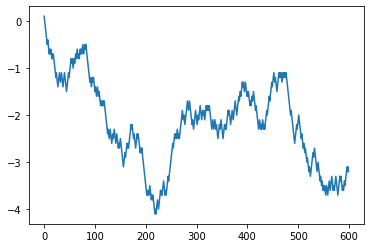

In [114]:
# Create a random walk
total_time = 60
dt = 0.1

max_dpwm_per_dt = 0.1

In [162]:
# get random integer between 0 and 0.1
# uniform distribution
dpwm = np.random.normal(0, max_dpwm_per_dt)
dpwm

0.0933019787158959

In [207]:
dpwm_std = 0.03
dt = 0.01

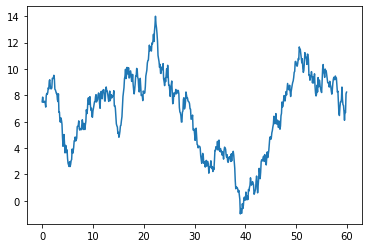

In [278]:
# Create a random walk
total_time = 60
dt = 0.1

max_dpwm_per_dt = 0.02

# get random integer between 0 and 0.1
# uniform distribution
dpwm = np.random.normal(0, max_dpwm_per_dt)

dpwm_std = 0.03

x = np.arange(0, total_time, dt)
y = np.zeros(len(x))

for i in range(len(x)):
    dpwm = np.random.normal(0, dpwm_std)
    y[i] = y[i-1] + dpwm


# map y to normal_speed_up_pwm and normal_speed_down_pwm
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y = y * (normal_speed_up_pwm + 4 - normal_speed_down_pwm * - 2 ) + normal_speed_down_pwm - 2

plt.plot(x, y)


In [323]:

log = []
-shared_global_data['motor_pos_encoder_pv'] > -bot_pos
for i in range(len(x)):
    if not -shared_global_data['motor_pos_encoder_pv'] > -bot_pos:
        shared_global_data['motor_pos_encoder_pv'] = normal_speed_up_pwm
    if not -shared_global_data['motor_pos_encoder_pv'] < -top_pos:
        shared_global_data['motor_pos_encoder_pv'] = normal_speed_down_pwm

    shared_global_data['motor_pwm_sp'] = y[i]

    # make copy of shared_global_data
    log.append(shared_global_data.copy())

    time.sleep(dt)

shared_global_data['motor_pwm_sp'] = static_pwm

KeyboardInterrupt: 

In [301]:
log[0]

{'motor_pwm_sp': 3.047523570163846,
 'motor_pos_encoder_pv': -5320783.0,
 'motor_torque_encoder_pv': 34.72092819213867,
 'motor_current_pv': 0.3499999940395355}

In [305]:
df = pd.DataFrame(log)

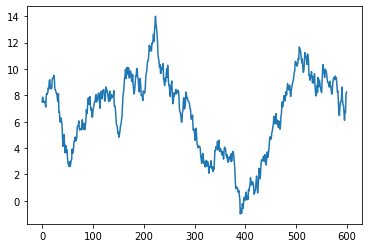

In [306]:
# Plot
plt.plot(df['motor_pwm_sp'])

In [284]:
df

,motor_pwm_sp,motor_pos_encoder_pv,motor_torque_encoder_pv,motor_current_pv
0,4,-5102463.0,33.296959,0.2625
1,4,-5102463.0,33.296959,0.2625
2,4,-5102463.0,33.296959,0.2625
3,4,-5102463.0,33.296959,0.2625
4,4,-5102463.0,33.296959,0.2625
...,...,...,...,...
595,4,-5102463.0,33.296959,0.2625
596,4,-5102463.0,33.296959,0.2625
597,4,-5102463.0,33.296959,0.2625
598,4,-5102463.0,33.296959,0.2625


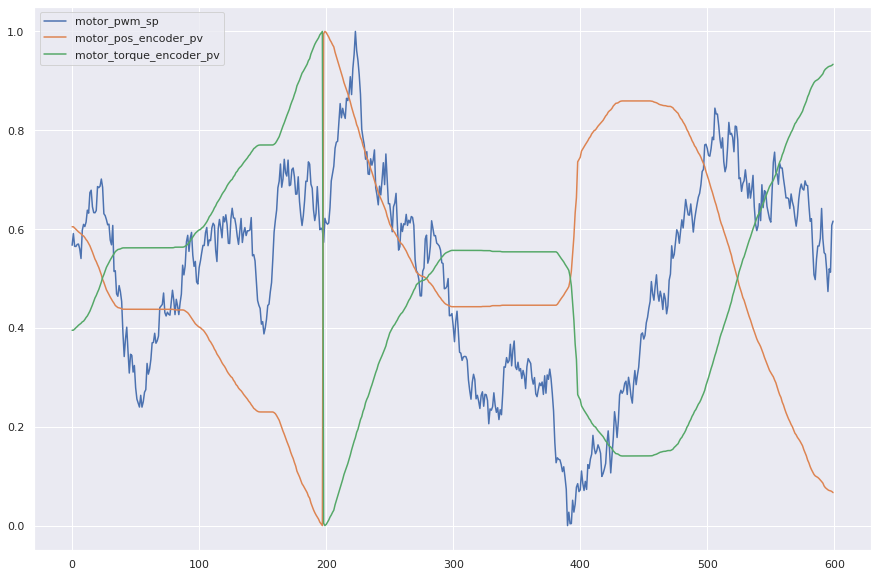

In [322]:
import seaborn as sns
sns.set()

# Plot all columns normalized
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm.drop('motor_current_pv', axis=1).plot()
# make the plot bigger
plt.gcf().set_size_inches(15, 10)
# remove motor_current_pv


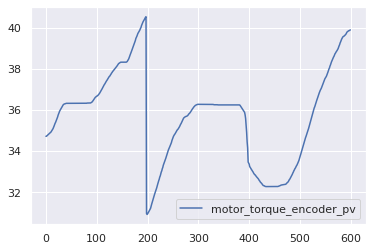

In [315]:
sns.lineplot(data=df[['motor_torque_encoder_pv']])